CW1 - Image Classification Group Assignment Using KERAS

In [ ]:
# installing visualkeras package
!pip install visualkeras

Mounting Google Drive

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Packages Importing

In [ ]:
# importing required packages...
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.applications import Xception as transfer_model
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import numpy as np
import visualkeras
import pickle
import os

GPU Check

In [ ]:
# checking for GPU..
# getting GPU name
device_name = tf.test.gpu_device_name()
# checking which GPU being used
if device_name != "/device:GPU:0":
    print("GPU device not found")
else:
    print("Found GPU at: {}".format(device_name))
    # changing the default 32 bits float to 16 for GPU

    tf.keras.mixed_precision.set_global_policy("mixed_float16")


Found GPU at: /device:GPU:0


Initializing Values

In [ ]:
# setting default values...
# setting image size
image_size = (128, 128)
# setting batch size
batch_size = 256
# setting epochs
epochs = 80
# setting monitor value for callback
monitor = "val_loss"
# setting learning rate
alpha = 0.0001
# setting early stopping
patience = 10

Paths

In [ ]:
# setting dataset paths...
# base path for dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Intel_ImageDataset"
# train path
train_path = os.path.join(data_path, "seg_train/seg_train")
# test path -- will be splited into two - validation and testing
test_path = os.path.join(data_path, "seg_test/seg_test")
# images path for prediction
pred_path = os.path.join(data_path, "seg_pred/seg_pred")

In [ ]:
# setting callbacks path...
# model checkpoint path -- saves the model with weight here
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/MLNN/CW1"
# training log file -- saves each epoch in csv file
logger_path = "/content/drive/MyDrive/Colab Notebooks/MLNN/CW1"
# path for dumping the model history as pickle
history_path = "/content/drive/MyDrive/Colab Notebooks/MLNN/CW1"

In [ ]:
# path for saving images created
image_save_path = "/content/drive/MyDrive/Colab Notebooks/MLNN/CW1"

Classes and Functions

In [ ]:
def model_train(model, train_data, validation_data, title, epochs=epochs,
                batch_size=batch_size, patience=patience, alpha=alpha):
    """
    model_train function to compile the model with passed datasets
    and optional number of epochs, batch size and patience for early
    stopages.

    Model's design and weights, training log file are saved using callback
    functionality
    """

    # compiling the model with adam optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    # setting callback for model saving
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(\
        filepath=os.path.join(checkpoint_path, f"{title}.keras"),
        monitor=monitor, save_best_only=True, mode="auto", verbose=1)
    # setting training early stop on loss
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor,
                                                      patience=patience,
                                                      verbose=1)
    # setting training log files
    logger = tf.keras.callbacks.CSVLogger(os.path.join(logger_path,
                                                       f"{title}.csv"),
                                          separator=",",
                                          append=False)
    # fitting the model with train and validation data
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=validation_data,
                        callbacks=[logger,
                                   model_checkpoint_callback,
                                   early_stopping])
    return history

Defining Models

In [ ]:
class custom_models:
    def __init__(self, image_size, num_classes):
        self.image_size = image_size
        self.num_classes = num_classes

    def data_augment_preprocess(self, model):
        """
        data_augment_preprocess function to create more
        images using keras augmentation layer
        """

        # adding the input layers with image size
        model.add(layers.Input(shape=(self.image_size[0],
                                      self.image_size[1], 3)))
        # adding horizontal flips
        model.add(layers.RandomFlip(mode="horizontal"))
        # adding rotation layer with random amount in  the range [-20% * 2pi, 20% * 2pi]
        model.add(layers.RandomRotation(0.2))
        # adding translation layer -- filling empty space
        model.add(layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"))
        # adding a zoom layer
        model.add(layers.RandomZoom(0.2, 0.2, fill_mode="nearest"))
        # rescaling layer -- normalize
        model.add(layers.Rescaling(1/255.0))
        return model

    def model1(self):
        """
        model1 function defines a simple CNN with
        data augmentation and preprocess layers
        and  one fully connected layer
        """

        # defining a sequential model
        model = models.Sequential()
        # adding the data augmentation and rescaling layer
        self.data_augment_preprocess(model)
        # adding covolutional layer with 32 filters
        model.add(layers.Conv2D(32,
                                kernel_size=(2, 2),
                                activation="relu"))
        # adding the max pool layer
        model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                      strides=2))
        # adding covolutional layer with 64 filters
        model.add(layers.Conv2D(64,
                                kernel_size=(3, 3),
                                activation="relu"))
        # adding the max pool layer
        model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                      strides=2))
        # flatting the last layer
        model.add(layers.Flatten())
        # adding the fully connected layer with kernel regularizer
        model.add(layers.Dense(32, activation="relu",
                  kernel_regularizer=regularizers.l2(0.001)))
        # adding regularization
        model.add(layers.Dropout(0.2))
        # adding output layer
        model.add(layers.Dense(self.num_classes,
                               activation="softmax"))
        # clearly the keras sequential session
        tf.keras.backend.clear_session()

        return model

    def model2(self):
        """
        model2 function defines a VGG-like CNN with
        data augmentation and preprocess layers
        and  two fully connected layer
        """

        # defining a sequential model
        model = models.Sequential()
        # adding the data augmentation and rescaling layer
        self.data_augment_preprocess(model)
        # adding covolutional layer with 64 filters
        model.add(layers.Conv2D(64,
                                kernel_size=(3, 3),
                                activation="relu"))
        # adding covolutional layer with 64 filters
        model.add(layers.Conv2D(64,
                                kernel_size=(3, 3),
                                activation="relu"))
        # adding the max pool layer
        model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                      strides=2))
        # adding covolutional layer with 128 filters
        model.add(layers.Conv2D(128,
                                kernel_size=(5, 5),
                                activation="relu"))
        # adding covolutional layer with 128 filters
        model.add(layers.Conv2D(128,
                                kernel_size=(5, 5),
                                activation="relu"))
        # adding the max pool layer
        model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                      strides=2))
        # flatting the last layer
        model.add(layers.Flatten())
        # adding the fully connected layer with kernel regularizer
        model.add(layers.Dense(64,
                               activation="relu",
                               kernel_regularizer=regularizers.l2(0.001)))
        # adding regularization
        model.add(layers.Dropout(0.5))
        # adding the fully connected layer with kernel regularizer
        model.add(layers.Dense(32,
                               activation="relu",
                               kernel_regularizer=regularizers.l2(0.001)))
        # adding regularization
        model.add(layers.Dropout(0.5))
        # adding output layer
        model.add(layers.Dense(self.num_classes, activation="softmax"))
        # clearly the keras sequential session
        tf.keras.backend.clear_session()

        return model

In [ ]:
class transfer_models:
    def __init__(self, image_size, num_classes):
        self.image_size = image_size
        self.num_classes = num_classes

    def data_augment_preprocess(self, model):
        # adding the input layers with image size
        model.add(layers.Input(shape=(self.image_size[0],
                                      self.image_size[1], 3)))
        # adding horizontal flips
        model.add(layers.RandomFlip(mode="horizontal"))
        # adding rotation layer with random amount in  the range [-20% * 2pi, 20% * 2pi]
        model.add(layers.RandomRotation(0.2))
        # adding translation layer -- filling empty space
        model.add(layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"))
        # adding a zoom layer
        model.add(layers.RandomZoom(0.2, 0.2, fill_mode="nearest"))
        # adding rescaling layer with offset -1, range[-1, 1] -- normalization
        model.add(layers.Rescaling(1/255.0, offset=-1))
        return model

    def base_model_build(self):
        # getting the models and weights for Xception CNN
        base_model = transfer_model(weights='imagenet', include_top=False,
                            input_shape=(self.image_size[0],
                                         self.image_size[1], 3))
        # looping over layers
        for layer in base_model.layers:
            # freezing layer for training
            layer.trainable = False

        return base_model

    def top_layer_v1(self, model):
        """
        top_layer_v1 adds the top layer to the
        base layer with one fully connected layer
        and a regularization
        """

        # adding the fully connected layer
        model.add(layers.Dense(128,
                               activation="relu"))
        # adding regularization
        model.add(layers.Dropout(0.2))
        return model

    def top_layer_v2(self, model):
        """
        top_layer_v2 adds the top layer to the
        base layer with three fully connected layer
        and a regularization
        """

        # adding the fully connected layer with kernel regularizer
        model.add(layers.Dense(1024,
                               kernel_regularizer=regularizers.l2(0.001),
                               activation="relu"))
        # adding the fully connected layer with kernel regularizer
        model.add(layers.Dense(512,
                               activation="relu"))
        # adding regularization
        model.add(layers.Dropout(0.3))
        # adding the fully connected layer with kernel regularizer
        model.add(layers.Dense(128,
                               activation="relu"))
        # adding regularization
        model.add(layers.Dropout(0.3))
        return model

    def top_layer_v3(self, model):
        """
        top_layer_v3 adds the top layer to the
        base layer with three fully connected layer
        and a regularization
        """

        # adding the fully connected layer
        model.add(layers.Dense(2048,
                               activation="relu"))
        # adding regularization
        model.add(layers.Dropout(0.2))
        # adding the fully connected layer
        model.add(layers.Dense(512,
                               activation="relu"))
        # adding regularization
        model.add(layers.Dropout(0.2))
        # adding the fully connected layer
        model.add(layers.Dense(128,
                               activation="relu"))
        # adding regularization
        model.add(layers.Dropout(0.2))
        return model

    def build_model(self):
        """
        build_model function creates three cnn with xception as base model
        and data augmentation and rescaling layers
        """

        # creating the base model
        base_model = self.base_model_build()

        # defining a sequential model
        model_v1 = models.Sequential()
        # adding the data augmentation and rescaling layer
        self.data_augment_preprocess(model_v1)
        # adding base model to the model
        model_v1.add(base_model)
        # flatting the last layer
        model_v1.add(layers.Flatten())
        # adding the top layers
        self.top_layer_v1(model_v1)
        # adding output layer
        model_v1.add(layers.Dense(self.num_classes,
                                  activation="softmax"))
        # clearly the keras sequential session
        tf.keras.backend.clear_session()

        # defining a sequential model
        model_v2 = models.Sequential()
        # adding the data augmentation and rescaling layer
        self.data_augment_preprocess(model_v2)
        # adding base model to the model
        model_v2.add(base_model)
        # flatting the last layer
        model_v2.add(layers.Flatten())
        # adding the top layers
        self.top_layer_v2(model_v2)
        # adding output layer
        model_v2.add(layers.Dense(self.num_classes,
                                  activation="softmax"))
        # clearly the keras sequential session
        tf.keras.backend.clear_session()

        # defining a sequential model
        model_v3 = models.Sequential()
        # adding the data augmentation and rescaling layer
        self.data_augment_preprocess(model_v3)
        # adding base model to the model
        model_v3.add(base_model)
        # flatting the last layer
        model_v3.add(layers.Flatten())
        # adding the top layers
        self.top_layer_v3(model_v3)
        # adding output layer
        model_v3.add(layers.Dense(self.num_classes,
                                  activation="softmax"))
        # clearly the keras sequential session
        tf.keras.backend.clear_session()

        return base_model, model_v1, model_v2, model_v3

In [ ]:

class plot:
    def model_design(self, model, title):
        """
        model_design function saves the designs of the models
        to the drive, in overall view and layered view
        """

        # saving overall view of model
        plot_model(model,
                   to_file=os.path.join(image_save_path,
                                        f"{title}_seq.png"),
                   show_shapes=True,
                   show_layer_names=True)
        # saving layered view
        visualkeras.layered_view(model,
                                 legend=True,
                                 to_file=os.path.\
                                 join(image_save_path,
                                      f"{title}_layered_view.png"))

    def plot_confusion_mat(self, true_labels,
                           perdicted_labels, class_names, title):
        """
        plot_confusion_mat function create a confusion matrix for the
        given ground truth and predicted values by the trained model
        """

        # calculating confusion matrix for the given values
        conf_mat = confusion_matrix(true_labels, perdicted_labels)
        # initializing the figure
        plt.figure(figsize=(10, 8))
        # ploting the confusion matrix as heatmap
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="viridis",
                    xticklabels=[class_names[i] \
                                 for i in range(len(class_names))],
                    yticklabels=[class_names[i] \
                                 for i in range(len(class_names))])
        # setting the title
        plt.title(f"Confusion Matrix for {title} Model")
        # setting the x-labels
        plt.xlabel("Predicted Labels")
        # setting the y-labels
        plt.ylabel("True Labels")
        # saving the plot
        plt.savefig(os.path.join(image_save_path,
                                 f"{title}_confusion_mat.png"))
        plt.show()

    def plot_imgs_class(self, data_df, title):
        """plot_imgs_class function plots """
        plt.figure()
        ax = data_df.plot(kind="pie", autopct="%1.1f%%", title=title)
        ax.yaxis.set_visible(False)
        plt.savefig(os.path.join(image_save_path, f"{title}.png"))
        plt.show()

    def num_imgs_batchs(self, data, title):
        num_imgs_batch = np.array([len(images) for images, _ in data])
        plt.figure(figsize=(12, 8))
        plt.bar(np.arange(0, len(num_imgs_batch)), num_imgs_batch)
        plt.xlabel("Batches")
        plt.ylabel("Number of Images")
        plt.title(f"{title} Images per Batch")
        plt.savefig(os.path.join(image_save_path,
                                 f"{title}_batch_images.png"))
        plt.show()

    def plot_read_images(self, data, class_names, image_num, title):
        # dispalying some of images
        subplot_layout_num = int(np.sqrt(image_num))
        plt.figure(figsize=(7, 7))
        for images, labels in data.take(1):
            for i in range(image_num):
                ax = plt.subplot(subplot_layout_num,
                                 subplot_layout_num, i+1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[labels[i]])
                plt.axis("off")
        plt.suptitle(title)
        plt.savefig(os.path.join(image_save_path, f"{title}_images.png"))
        plt.show()

    def plot_curves(self, history, metric, title):
        val_metric = f"val_{metric}"
        plt.plot(history.history[metric], label=metric)
        plt.plot(history.history[val_metric], label=val_metric)
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.legend(loc="best")
        plt.title(f"{title}-{metric} vs {val_metric}")
        plt.savefig(os.path.join(image_save_path,
                                 f"{title}_{metric}.png"))
        plt.show()

    def intermediate_layer_output(self, data, model, layer,
                                  model_name, image_num=9):
        intermediate_layer_output = models.Model(input=model.input,
                                                 outputs=\
                                                 model.get_layer(layer).\
                                                 output).predict(data)
        plt.figure(figsize=(7, 7))
        random_image_i = np.random.ranint(0, len(data), image_num)
        subplot_layout_num = int(np.sqrt(image_num))
        subplot_layout_seq = 1
        for i in random_image_i:
            plt.subplot(subplot_layout_num,
                        subplot_layout_num,
                        subplot_layout_seq)
            plt.imshow(intermediate_layer_output[i].astype("unit8"))
            plt.axis("off")
        plt.suptitle(f"{model_name} {layer} layer output".capitalize())
        plt.savefig(os.path.join(image_save_path,
                                 f"{model_name}_{layer}_output.png"))
        plt.show()

In [ ]:
class data:
    def num_image_class(self, data, class_names, title):
        # showing number of images per class in train dataset
        labels = [labels.numpy() for _, labels in data.unbatch()]
        class_counts = pd.Series(labels).value_counts().\
                                    sort_index().rename(title)
        class_counts.index = class_names
        # class_counts.rename(title, inplace=True)
        print(f"Number of Images per Class for {title}:\n{class_counts}")
        return class_counts.to_frame()

    def read_data(self, path, validation_split=0, subset=None):
        return tf.keras.utils.image_dataset_from_directory(
            path,
            labels="inferred",
            label_mode="int",
            class_names=None,
            color_mode="rgb",
            batch_size=batch_size,
            image_size=image_size,
            shuffle=True,
            seed=32,
            validation_split=validation_split,
            subset=subset,
            interpolation="bilinear",
            follow_links=False,
            crop_to_aspect_ratio=True)

    def load_data(self, train_path=train_path, test_path=test_path,
                  save=False, save_path=""):
        # reading the train data
        train_data = self.read_data(train_path)
        # reading the test data
        data = self.read_data(test_path)
        # splittign given data into 50% validation
        validation_data = data.take(int(0.5*data.cardinality()\
                                        .numpy())).shuffle(100)
        # splittign given data into 50% validation
        test_data = data.skip(int(0.5*data.cardinality().numpy()))
        return train_data, validation_data, test_data

In [ ]:
# creating an object for class plot
plot = plot()
# creating an object for class data
data_obj = data()

Loading Data

In [ ]:
# loading train, validation and test data
train_data, validation_data, test_data = data_obj.load_data()

Found 14237 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
# saving the class names
class_names = train_data.class_names
print(f"The Class Names in the Dataset are:\n{class_names}")

The Class Names in the Dataset are:
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# storing number classes in the dataset
num_classes = len(train_data.class_names)
print(f"The Number of Classes in the Dataset are: {num_classes}")

The Number of Classes in the Dataset are: 6


In [ ]:
# getting all the labels/classes index from the test data
with tf.device("/device:GPU:0"):
    test_true_labels = np.array([label.numpy() for _,
                             label in test_data.unbatch()])

In [ ]:
# finding and storing total number of images per calss in...
with tf.device("/device:GPU:0"):
    # train_dataset
    train_num = data_obj.num_image_class(train_data, class_names, "Training")
    # validation_dataset
    validation_num = data_obj.num_image_class(validation_data, class_names,
                                            "Validation")
    # test_dataset
    test_num = data_obj.num_image_class(test_data, class_names, "Testing")

Number of Images per Class for Training:
buildings    2191
forest       2361
glacier      2444
mountain     2545
sea          2274
street       2422
Name: Training, dtype: int64
Number of Images per Class for Validation:
buildings    228
forest       237
glacier      289
mountain     283
sea          265
street       234
Name: Validation, dtype: int64
Number of Images per Class for Testing:
buildings    214
forest       238
glacier      252
mountain     259
sea          257
street       244
Name: Testing, dtype: int64


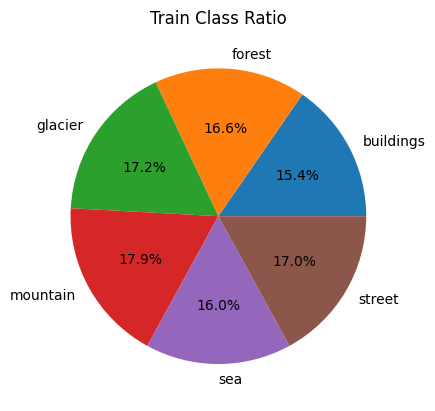

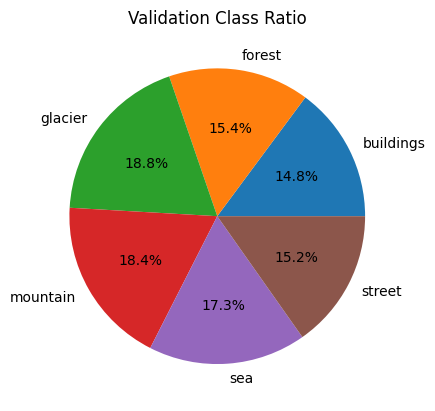

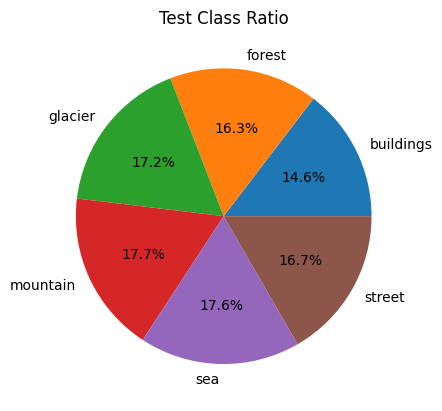

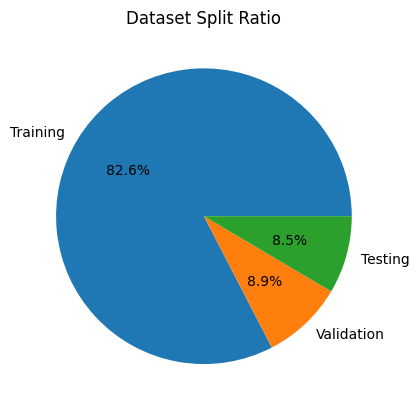

In [ ]:
# finding and storing image ratios b/w each class for...
# train_dataset
plot.plot_imgs_class(train_num.iloc[:, 0], "Train Class Ratio")
# validation_dataset
plot.plot_imgs_class(validation_num.iloc[:, 0], "Validation Class Ratio")
# testion_dataset
plot.plot_imgs_class(test_num.iloc[:, 0], "Test Class Ratio")
# finding and storing image of train, validation and test split
plot.plot_imgs_class(pd.concat([train_num.sum(),
                                validation_num.sum(),
                                test_num.sum()],
                               axis=0), "Dataset Split Ratio")

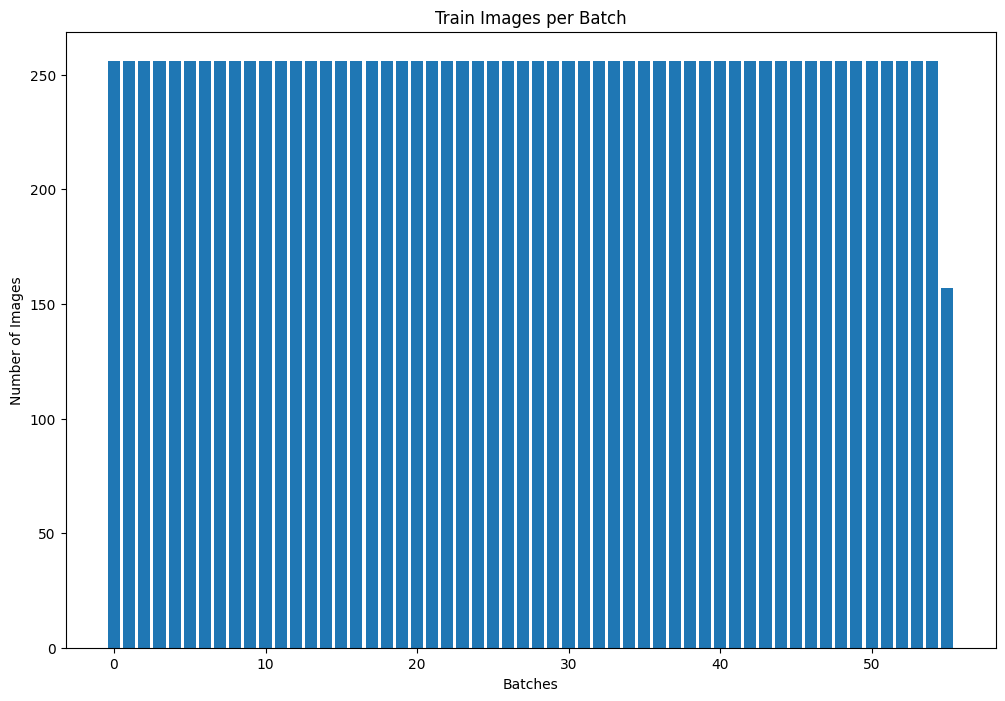

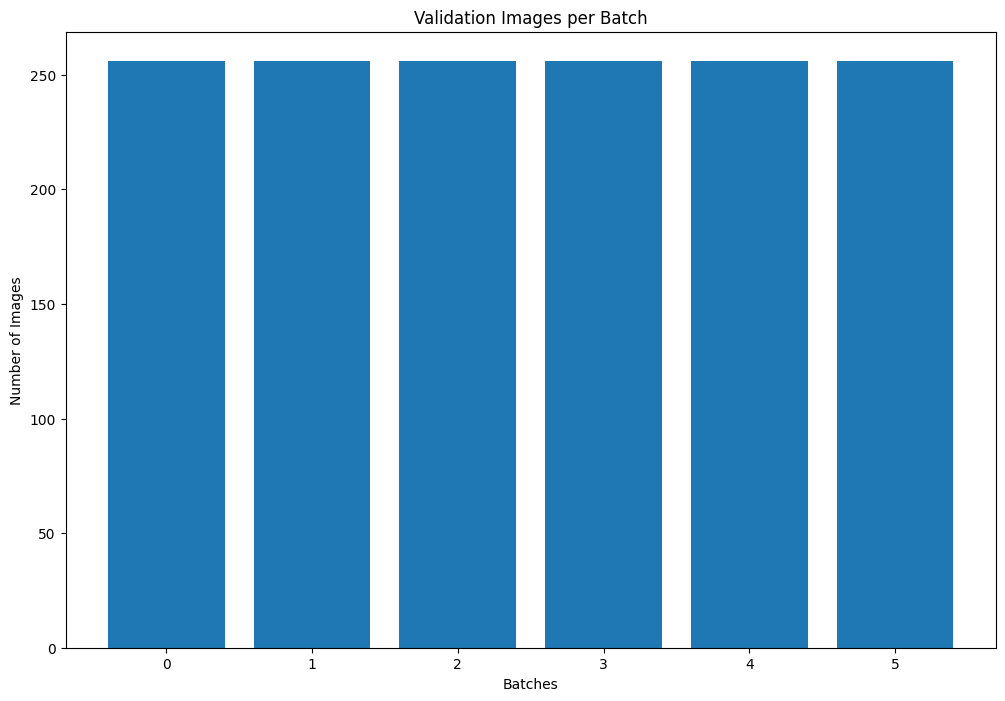

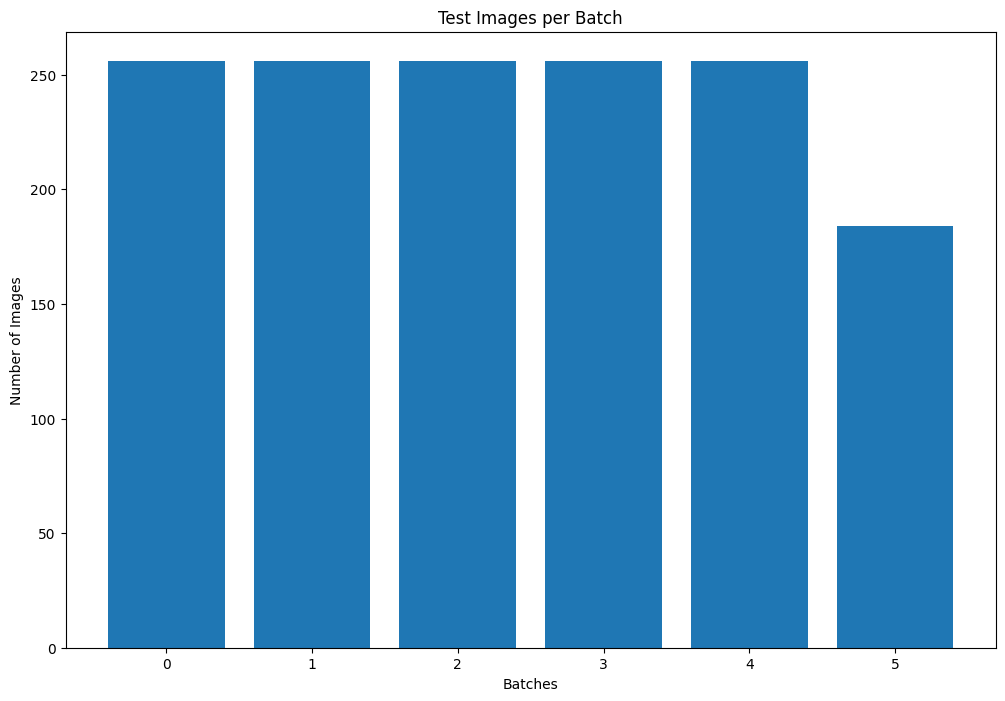

In [ ]:
# finding and ploting number of images per batch in...
# train_dataset
plot.num_imgs_batchs(train_data, "Train")
# validation_dataset
plot.num_imgs_batchs(validation_data, "Validation")
# test_dataset
plot.num_imgs_batchs(test_data, "Test")

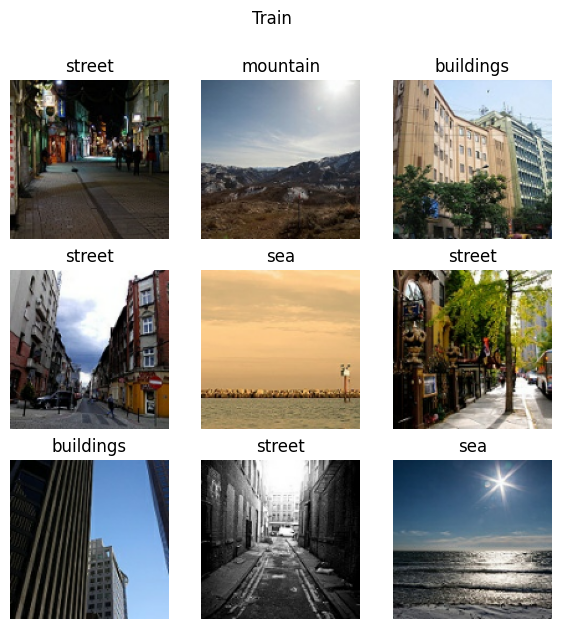

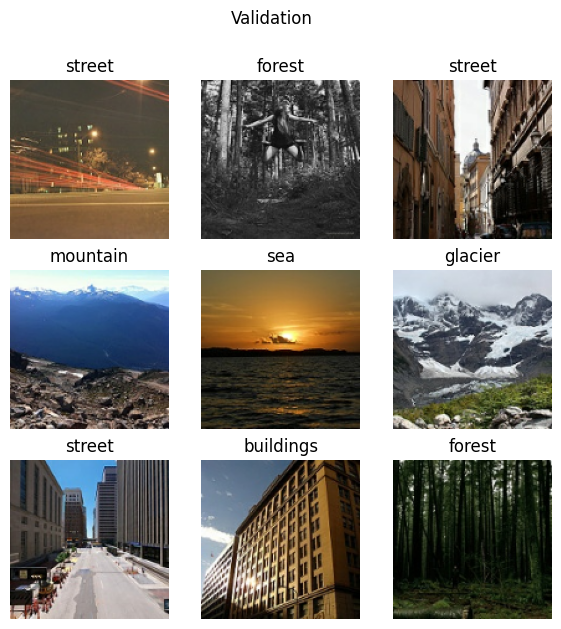

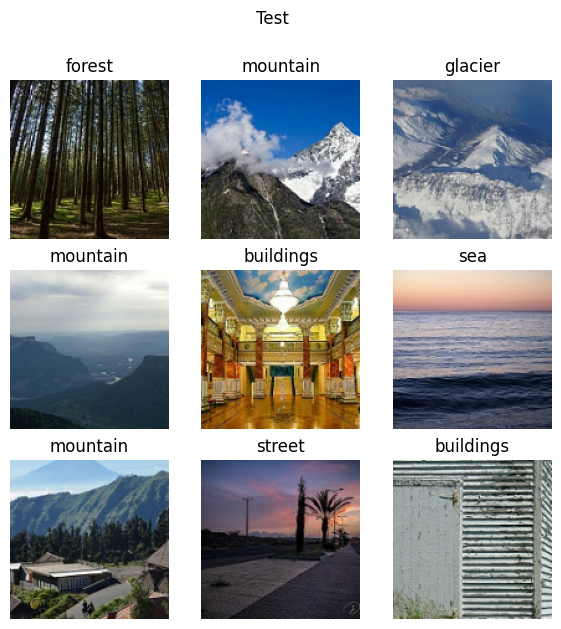

In [ ]:
# ploting images from read dataset for...
# train_dataset
plot.plot_read_images(train_data, class_names, 9, "Train")
# validation_dataset
plot.plot_read_images(validation_data, class_names, 9, "Validation")
# test_dataset
plot.plot_read_images(test_data, class_names, 9, "Test")

[Autotune](https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance
)

In [ ]:
# creating a autotune variable
AUTOTUNE = tf.data.AUTOTUNE
# setting prefect for...
# train_dataset
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# validation_dataset
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
# test_dataset
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

Transfer Learning -- Xception Model

In [ ]:
# creating an object of class transfer_models
transfer = transfer_models(image_size, num_classes)
# loading all the models
base_model, transfer_model_v1, transfer_model_v2, transfer_model_v3 = \
                                                transfer.build_model()

83683744/83683744 [==============================] - 1s 0us/step


Base_Model

In [ ]:
# saving the base_model's design
plot.model_design(base_model, "Xception_Model")
# printing base_model's summary
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 63, 63, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 63, 63, 32)           0         ['block1_conv1_bn[0][0]

Xception with custom top layers -- model_v1

In [ ]:
# saving the transfer_model_v1's design
plot.model_design(transfer_model_v1, "Xception_Model_V1")
# printing transfer_model_v1's summary
transfer_model_v1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 128, 128, 3)       0         
 ation)                                                          
                                                                 
 random_translation (Random  (None, 128, 128, 3)       0         
 Translation)                                                    
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        2

In [ ]:
# training the transfer_model_v1
with tf.device("/device:GPU:0"):
    transfer_model_v1_histoty = model_train(transfer_model_v1,
                                            train_data,
                                            validation_data,
                                            "Xcepion_Model_v1", batch_size=1024)

Epoch 1/80
55/56 [============================>.] - ETA: 0s - loss: 0.8628 - accuracy: 0.6844
Epoch 1: val_loss improved from inf to 0.45296, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v1.keras
56/56 [==============================] - 37s 160ms/step - loss: 0.8564 - accuracy: 0.6869 - val_loss: 0.4530 - val_accuracy: 0.8503
Epoch 2/80
55/56 [============================>.] - ETA: 0s - loss: 0.6275 - accuracy: 0.7723
Epoch 2: val_loss improved from 0.45296 to 0.40340, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v1.keras
56/56 [==============================] - 3s 61ms/step - loss: 0.6271 - accuracy: 0.7726 - val_loss: 0.4034 - val_accuracy: 0.8594
Epoch 3/80
55/56 [============================>.] - ETA: 0s - loss: 0.5806 - accuracy: 0.7884
Epoch 3: val_loss improved from 0.40340 to 0.39966, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v1.keras
56/56 [==============================] - 3s

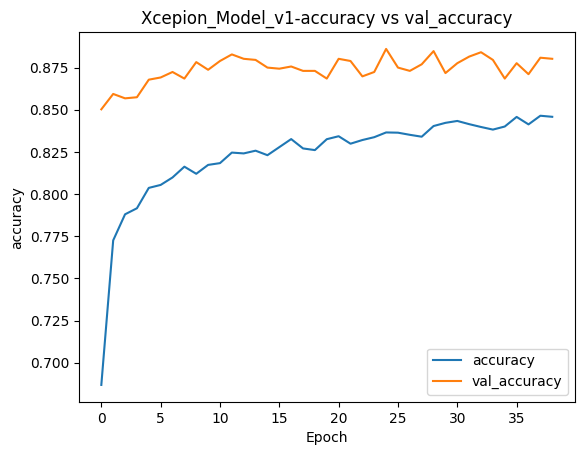

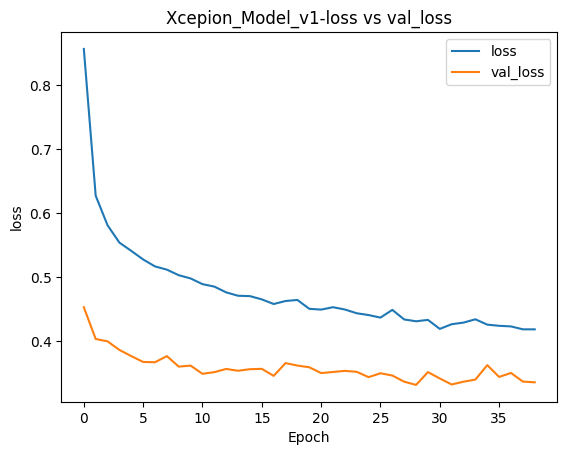

In [ ]:
# plotting accuracy for transfer_model_v1
plot.plot_curves(transfer_model_v1_histoty, "accuracy",
                 "Xcepion_Model_v1")
# plotting loss for transfer_model_v1 -- learning curve
plot.plot_curves(transfer_model_v1_histoty, "loss", "Xcepion_Model_v1")

Model_v1 of transfer learning is overfitting

Xception with custom top layers -- model_v2

In [ ]:
# saving the transfer_model_v2's design
plot.model_design(transfer_model_v2, "Xception_Model_V2")
# printing transfer_model_v2's summary
transfer_model_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 128, 128, 3)       0         
 ation)                                                          
                                                                 
 random_translation (Random  (None, 128, 128, 3)       0         
 Translation)                                                    
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        2

In [ ]:
# training the transfer_model_v2
with tf.device("/device:GPU:0"):
    transfer_model_v2_histoty = model_train(transfer_model_v2,
                                            train_data,
                                            validation_data,
                                            "Xcepion_Model_v2", batch_size=1024)

Epoch 1/80
55/56 [============================>.] - ETA: 0s - loss: 2.8434 - accuracy: 0.6605
Epoch 1: val_loss improved from inf to 2.28571, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v2.keras
56/56 [==============================] - 11s 121ms/step - loss: 2.8368 - accuracy: 0.6621 - val_loss: 2.2857 - val_accuracy: 0.8438
Epoch 2/80
55/56 [============================>.] - ETA: 0s - loss: 2.4039 - accuracy: 0.7489
Epoch 2: val_loss improved from 2.28571 to 2.02442, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v2.keras
56/56 [==============================] - 6s 105ms/step - loss: 2.4015 - accuracy: 0.7490 - val_loss: 2.0244 - val_accuracy: 0.8490
Epoch 3/80
55/56 [============================>.] - ETA: 0s - loss: 2.1522 - accuracy: 0.7713
Epoch 3: val_loss improved from 2.02442 to 1.83532, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v2.keras
56/56 [==============================] - 6

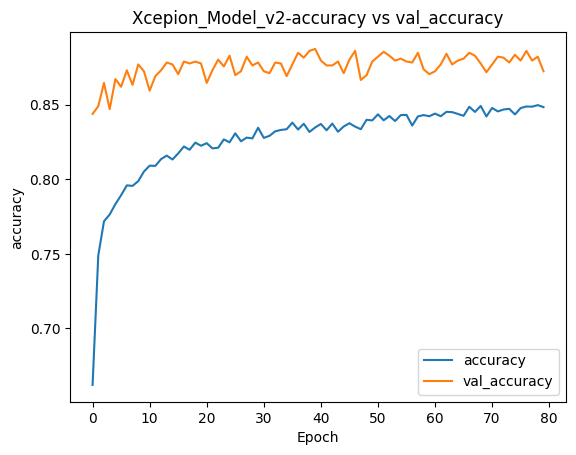

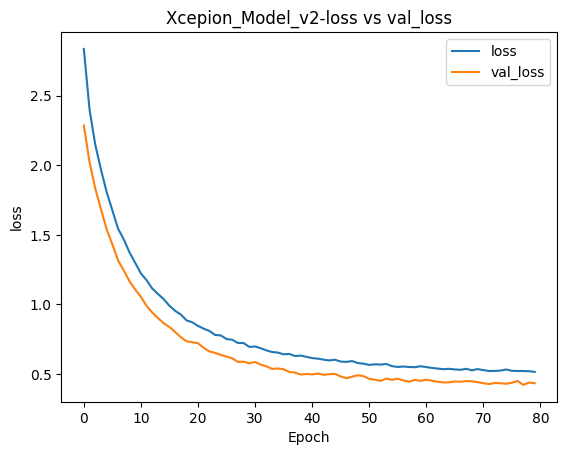

In [ ]:
# plotting accuracy for transfer_model_v2
plot.plot_curves(transfer_model_v2_histoty, "accuracy",
                 "Xcepion_Model_v2")
# plotting loss for transfer_model_v2 -- learning curve
plot.plot_curves(transfer_model_v2_histoty, "loss", "Xcepion_Model_v2")

Model_v2 also is underfitting for transferlearning, but the loss and accuracy are much closer for training and validation dataset

Xception with custom top layers -- model_v3

In [ ]:
# saving the transfer_model_v3's design
plot.model_design(transfer_model_v3, "Xception_Model_V3")
# printing transfer_model_v3's summary
transfer_model_v3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 128, 128, 3)       0         
 ation)                                                          
                                                                 
 random_translation (Random  (None, 128, 128, 3)       0         
 Translation)                                                    
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        2

In [ ]:
# training the transfer_model_v3
with tf.device("/device:GPU:0"):
    transfer_model_v3_histoty = model_train(transfer_model_v3,
                                            train_data,
                                            validation_data,
                                            "Xcepion_Model_v3",
                                            batch_size=1024)

Epoch 1/80
56/56 [==============================] - ETA: 0s - loss: 0.9148 - accuracy: 0.6642
Epoch 1: val_loss improved from inf to 0.43986, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v3.keras
56/56 [==============================] - 14s 172ms/step - loss: 0.9148 - accuracy: 0.6642 - val_loss: 0.4399 - val_accuracy: 0.8431
Epoch 2/80
55/56 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.7514
Epoch 2: val_loss improved from 0.43986 to 0.41748, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v3.keras
56/56 [==============================] - 9s 159ms/step - loss: 0.6911 - accuracy: 0.7521 - val_loss: 0.4175 - val_accuracy: 0.8542
Epoch 3/80
55/56 [============================>.] - ETA: 0s - loss: 0.6359 - accuracy: 0.7677
Epoch 3: val_loss improved from 0.41748 to 0.39518, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v3.keras
56/56 [==============================] - 1

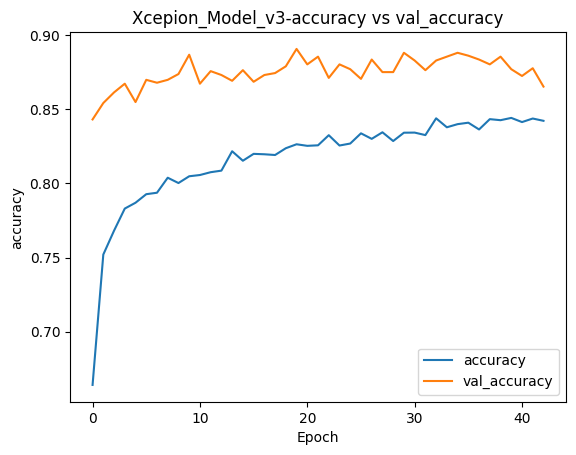

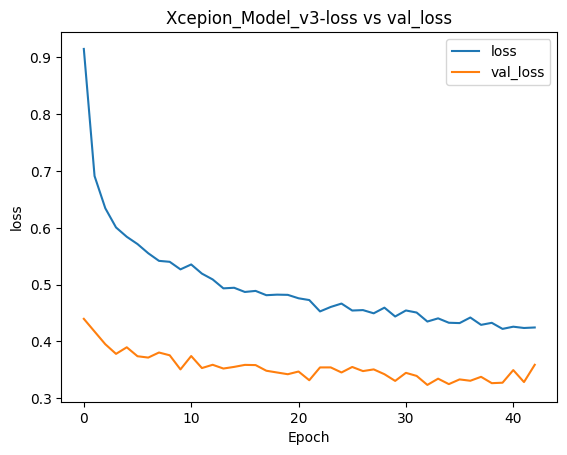

In [ ]:
# plotting accuracy for transfer_model_v3
plot.plot_curves(transfer_model_v3_histoty, "accuracy",
                 "Xcepion_Model_v3")
# plotting loss for transfer_model_v3 -- learning curve
plot.plot_curves(transfer_model_v3_histoty, "loss", "Xcepion_Model_v3")

Model 2 selected

In [ ]:
_, _, transfer_model_v2_200ep, _ = transfer.build_model()

In [ ]:
# training the transfer_model_v2
with tf.device("/device:GPU:0"):
    transfer_model_v2_200ep_histoty = model_train(transfer_model_v2_200ep,
                                            train_data,
                                            validation_data,
                                            "Xcepion_Model_v2_200ep",
                                            batch_size=1024, epochs=200)

Epoch 1/200
55/56 [============================>.] - ETA: 0s - loss: 2.8267 - accuracy: 0.6660
Epoch 1: val_loss improved from inf to 2.27105, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v2_200ep.keras
56/56 [==============================] - 12s 132ms/step - loss: 2.8216 - accuracy: 0.6680 - val_loss: 2.2711 - val_accuracy: 0.8470
Epoch 2/200
55/56 [============================>.] - ETA: 0s - loss: 2.4154 - accuracy: 0.7523
Epoch 2: val_loss improved from 2.27105 to 2.02803, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v2_200ep.keras
56/56 [==============================] - 6s 106ms/step - loss: 2.4138 - accuracy: 0.7520 - val_loss: 2.0280 - val_accuracy: 0.8685
Epoch 3/200
55/56 [============================>.] - ETA: 0s - loss: 2.1766 - accuracy: 0.7758
Epoch 3: val_loss improved from 2.02803 to 1.85856, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xcepion_Model_v2_200ep.keras
56/56 [==============

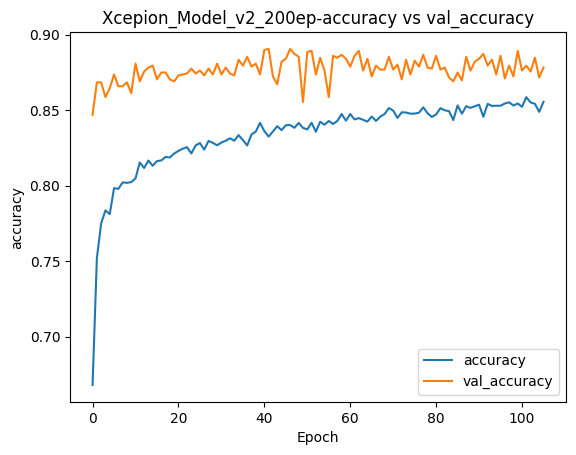

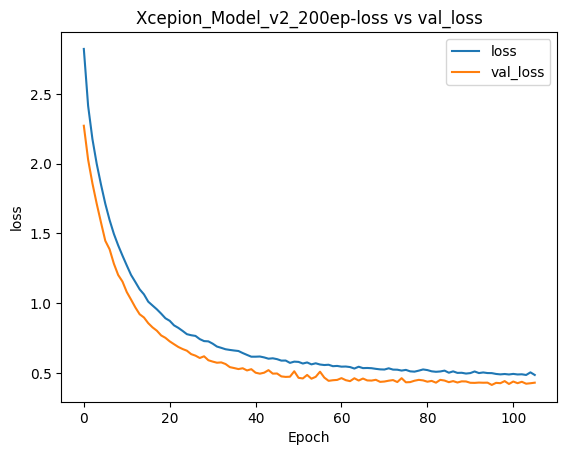

In [ ]:
# plotting accuracy for transfer_model_v2
plot.plot_curves(transfer_model_v2_200ep_histoty, "accuracy",
                 "Xcepion_Model_v2_200ep")
# plotting loss for transfer_model_v2 -- learning curve
plot.plot_curves(transfer_model_v2_200ep_histoty, "loss", "Xcepion_Model_v2_200ep")

In [ ]:
# evaluating the model on testing data
transfer_model_test_metric = transfer_model_v2_200ep.evaluate(test_data)

6/6 [==============================] - 5s 195ms/step - loss: 0.3627 - accuracy: 0.8982


In [ ]:
# predicting labels for the testing data
transfer_model_v2_80ep_labels_predict = transfer_model_v2.predict(test_data)

6/6 [==============================] - 1s 28ms/step


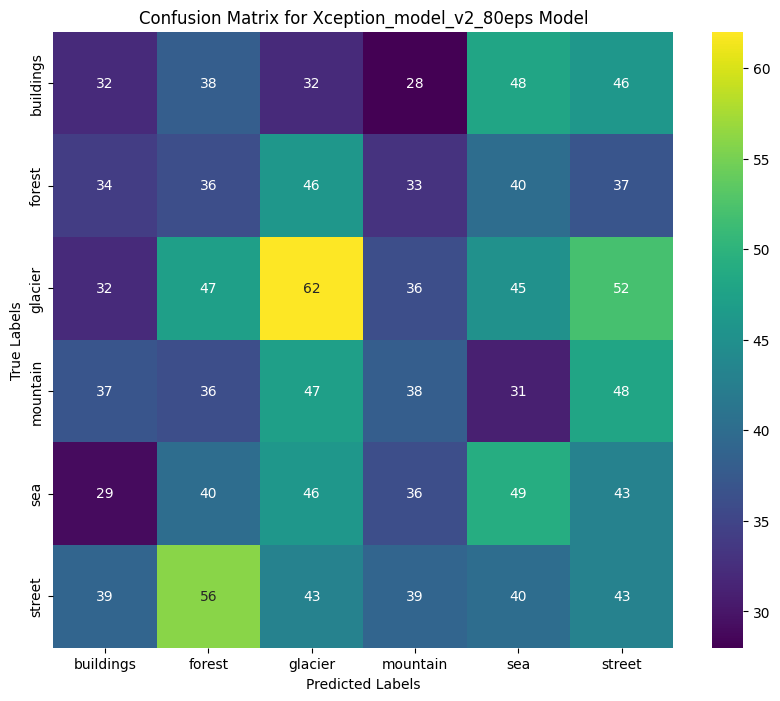

In [ ]:
# ploting the confusiion matrix for transfer_model_v3
plot.plot_confusion_mat(test_true_labels,
                        np.argmax(transfer_model_v2_80ep_labels_predict, axis=1),
                                  class_names,"Xception_model_v2_80eps")

In [ ]:
transfer_model_labels_predict = transfer_model_v2_200ep.predict(test_data)

6/6 [==============================] - 1s 29ms/step


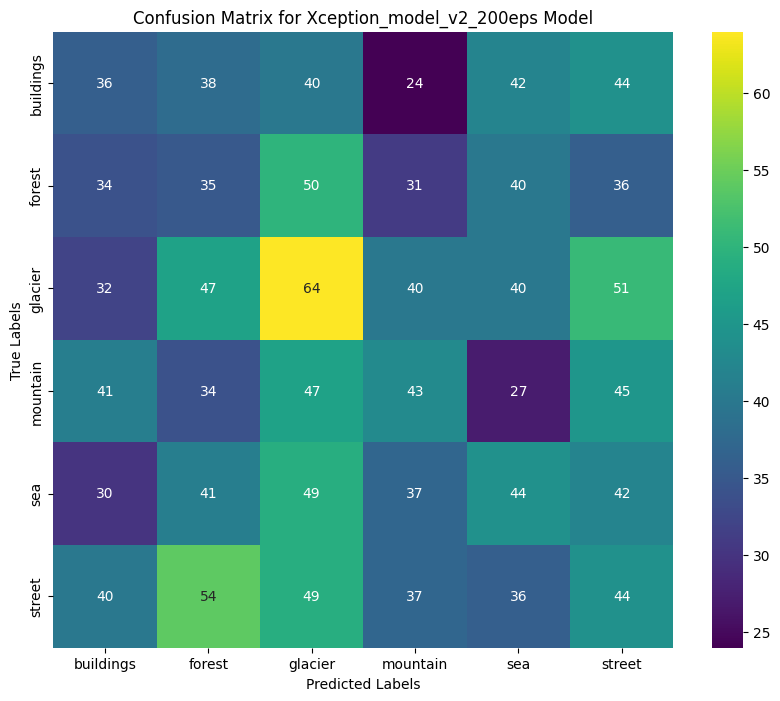

In [ ]:
# ploting the confusiion matrix for transfer_model_v3
plot.plot_confusion_mat(test_true_labels,
                        np.argmax(transfer_model_labels_predict, axis=1),
                                  class_names,"Xception_model_v2_200eps")

Fine Tuning

In [ ]:
for layer in base_model.layers[: 100]:
    layer.trainable = True

In [ ]:
with tf.device("/device:GPU:0"):
    fine_tune_history = model_train(transfer_model_v2_200ep,
                                    train_data,
                                    validation_data,
                                    epochs=20,
                                    batch_size=1024,
                                    patience=10,
                                    alpha=1e-05,
                                    title="Xception_model_v2_200eps_fine_tune")

Epoch 1/20
55/56 [============================>.] - ETA: 0s - loss: 0.4555 - accuracy: 0.8650
Epoch 1: val_loss improved from inf to 0.41271, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xception_model_v2_200eps_fine_tune.keras
56/56 [==============================] - 11s 121ms/step - loss: 0.4556 - accuracy: 0.8644 - val_loss: 0.4127 - val_accuracy: 0.8887
Epoch 2/20
55/56 [============================>.] - ETA: 0s - loss: 0.4600 - accuracy: 0.8632
Epoch 2: val_loss improved from 0.41271 to 0.41180, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xception_model_v2_200eps_fine_tune.keras
56/56 [==============================] - 6s 107ms/step - loss: 0.4604 - accuracy: 0.8628 - val_loss: 0.4118 - val_accuracy: 0.8867
Epoch 3/20
55/56 [============================>.] - ETA: 0s - loss: 0.4457 - accuracy: 0.8689
Epoch 3: val_loss improved from 0.41180 to 0.40571, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/Xception_model_v2_200eps_fine

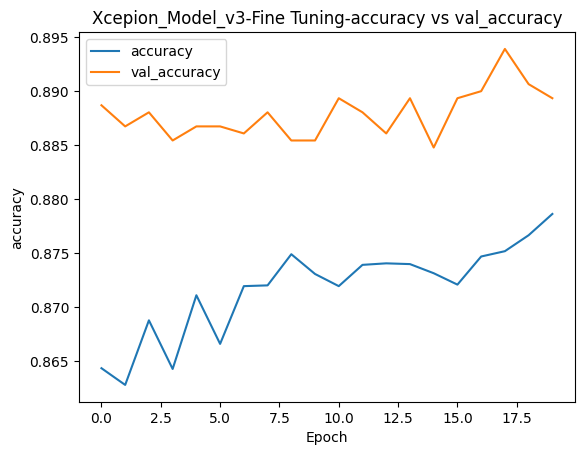

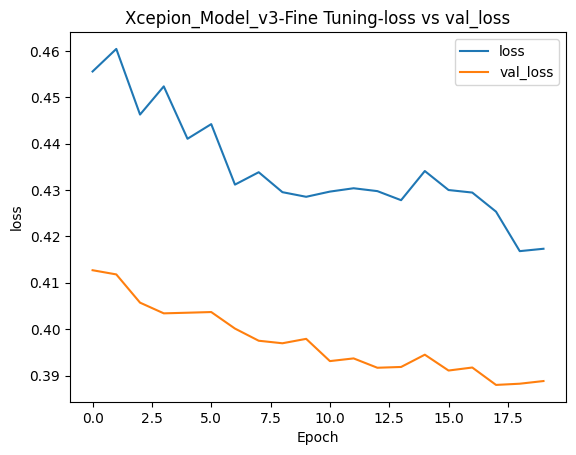

In [ ]:
# plotting accuracy for transfer_model_v3
plot.plot_curves(fine_tune_history, "accuracy",
                 "Xcepion_Model_v3-Fine Tuning")
# plotting loss for transfer_model_v3 -- learning curve
plot.plot_curves(fine_tune_history, "loss",
                 "Xcepion_Model_v3-Fine Tuning")

In [ ]:
# evaluating the model on testing data
fine_tune_test_metric = transfer_model_v2_200ep.evaluate(test_data)

6/6 [==============================] - 0s 31ms/step - loss: 0.3318 - accuracy: 0.9057


In [ ]:
# predicting labels for the testing data
fine_tune_labels_predict = transfer_model_v2_200ep.predict(test_data)

6/6 [==============================] - 1s 30ms/step


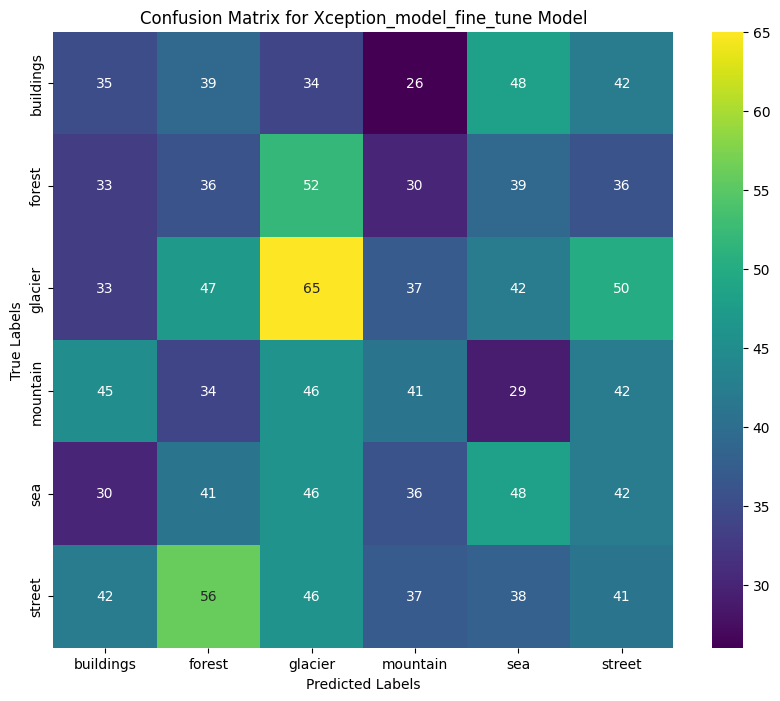

In [ ]:
# ploting the confusiion matrix for transfer_model_v3
plot.plot_confusion_mat(test_true_labels, np.argmax(fine_tune_labels_predict, axis=1),
                      class_names, "Xception_model_fine_tune")

Custom Model

In [ ]:
# creating an object of custom models
custom_model = custom_models(image_size, num_classes)

Custom Model -model1

In [ ]:
# building custom_model1
custom_model1  = custom_model.model1()

In [ ]:
# saving the custom_model1's design
plot.model_design(custom_model1, "Custom_Model1")
# printing custom_model1's summary
custom_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 128, 128, 3)       0         
 otation)                                                        
                                                                 
 random_translation_1 (Rand  (None, 128, 128, 3)       0         
 omTranslation)                                                  
                                                                 
 random_zoom_1 (RandomZoom)  (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 127, 32)     

In [ ]:
# training the custom_model1
with tf.device("/device:GPU:0"):
    custom_model1_histoty = model_train(custom_model1,
                                        train_data,
                                        validation_data,
                                        "custom_Model1",batch_size=1024)

Epoch 1/80
56/56 [==============================] - ETA: 0s - loss: 1.4226 - accuracy: 0.4524
Epoch 1: val_loss improved from inf to 1.50418, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/custom_Model1.keras
56/56 [==============================] - 4s 37ms/step - loss: 1.4226 - accuracy: 0.4524 - val_loss: 1.5042 - val_accuracy: 0.4440
Epoch 2/80
56/56 [==============================] - ETA: 0s - loss: 1.3682 - accuracy: 0.4640
Epoch 2: val_loss improved from 1.50418 to 1.44661, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/custom_Model1.keras
56/56 [==============================] - 2s 33ms/step - loss: 1.3682 - accuracy: 0.4640 - val_loss: 1.4466 - val_accuracy: 0.4727
Epoch 3/80
56/56 [==============================] - ETA: 0s - loss: 1.3498 - accuracy: 0.4755
Epoch 3: val_loss improved from 1.44661 to 1.38411, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/custom_Model1.keras
56/56 [==============================] - 2s 33ms/step 

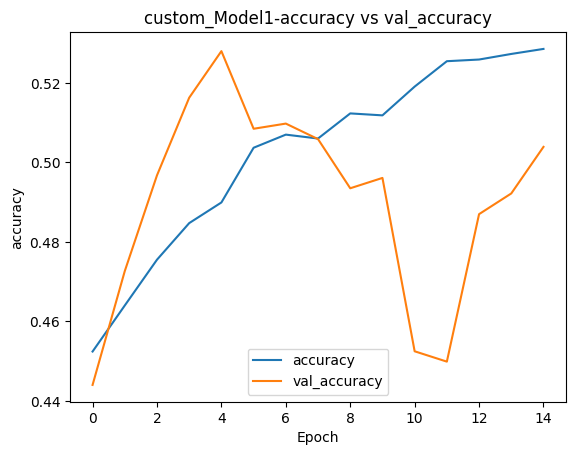

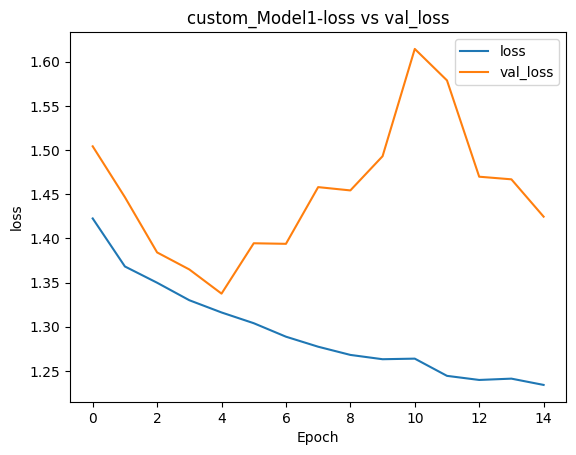

In [ ]:
# plotting accuracy for custom_model1
plot.plot_curves(custom_model1_histoty, "accuracy",
                 "custom_Model1")
# plotting loss for custom_model1 -- learning curve
plot.plot_curves(custom_model1_histoty, "loss", "custom_Model1")

Custom Model -model2

In [ ]:
# building custom_model2
custom_model2  = custom_model.model2()

In [ ]:
# saving the custom_model2's design
plot.model_design(custom_model2, "Custom_Model2")
# printing custom_model2's summary
custom_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 128, 128, 3)       0         
 ation)                                                          
                                                                 
 random_translation (Random  (None, 128, 128, 3)       0         
 Translation)                                                    
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1

In [ ]:
# training the custom_model2
with tf.device("/device:GPU:0"):
    custom_model2_histoty = model_train(custom_model2,
                                        train_data,
                                        validation_data,
                                        "custom_Model2", batch_size=1024)

Epoch 1/80
56/56 [==============================] - ETA: 0s - loss: 1.8619 - accuracy: 0.2240
Epoch 1: val_loss improved from inf to 1.66533, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/custom_Model2.keras
56/56 [==============================] - 105s 724ms/step - loss: 1.8619 - accuracy: 0.2240 - val_loss: 1.6653 - val_accuracy: 0.3678
Epoch 2/80
56/56 [==============================] - ETA: 0s - loss: 1.7220 - accuracy: 0.2935
Epoch 2: val_loss improved from 1.66533 to 1.53779, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/custom_Model2.keras
56/56 [==============================] - 4s 72ms/step - loss: 1.7220 - accuracy: 0.2935 - val_loss: 1.5378 - val_accuracy: 0.4082
Epoch 3/80
56/56 [==============================] - ETA: 0s - loss: 1.6430 - accuracy: 0.3317
Epoch 3: val_loss improved from 1.53779 to 1.40502, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/custom_Model2.keras
56/56 [==============================] - 4s 72ms/st

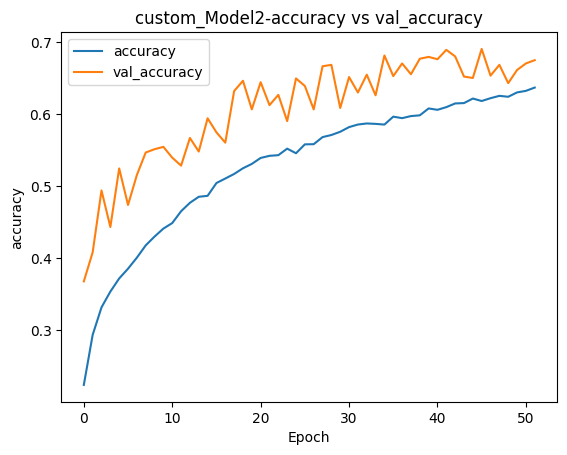

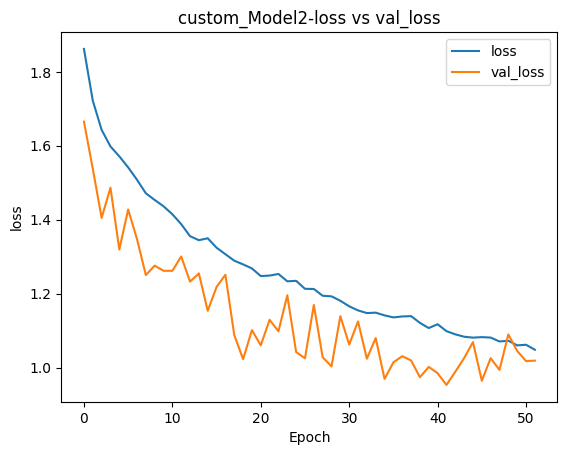

In [ ]:
# plotting accuracy for custom_model2
plot.plot_curves(custom_model2_histoty, "accuracy",
                 "custom_Model2")
# plotting loss for custom_model2 -- learning curve
plot.plot_curves(custom_model2_histoty, "loss", "custom_Model2")

Model_2 selected

In [ ]:
custom_model2_200ep  = custom_model.model2()

In [ ]:
# training the custom_model2
with tf.device("/device:GPU:0"):
    custom_model2_histoty_200ep = model_train(custom_model2_200ep,
                                              train_data,
                                              validation_data,
                                              "custom_Model2_200ep",
                                              batch_size=1024,
                                              epochs=200,patience=20)

Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 1.8376 - accuracy: 0.2411
Epoch 1: val_loss improved from inf to 1.60828, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/custom_Model2_200ep.keras
56/56 [==============================] - 7s 76ms/step - loss: 1.8376 - accuracy: 0.2411 - val_loss: 1.6083 - val_accuracy: 0.3945
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 1.6847 - accuracy: 0.3200
Epoch 2: val_loss improved from 1.60828 to 1.45498, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/custom_Model2_200ep.keras
56/56 [==============================] - 4s 71ms/step - loss: 1.6847 - accuracy: 0.3200 - val_loss: 1.4550 - val_accuracy: 0.4954
Epoch 3/200
56/56 [==============================] - ETA: 0s - loss: 1.6164 - accuracy: 0.3537
Epoch 3: val_loss improved from 1.45498 to 1.38923, saving model to /content/drive/MyDrive/Colab Notebooks/MLNN/CW1/custom_Model2_200ep.keras
56/56 [==========================

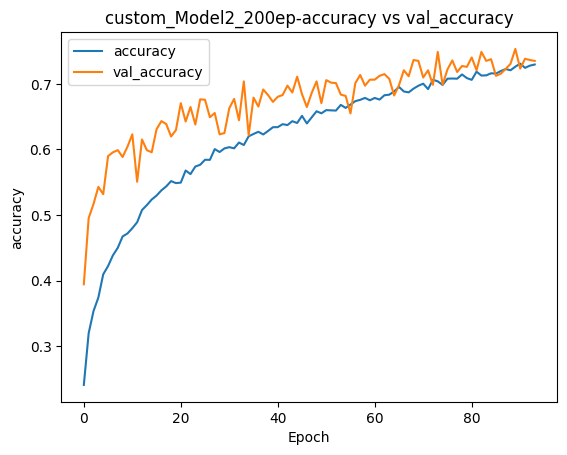

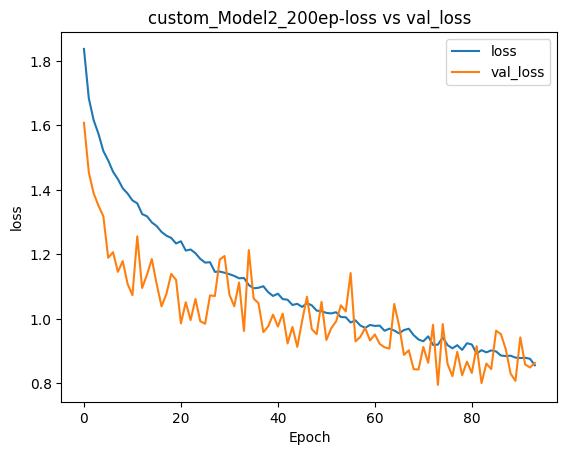

In [ ]:
# plotting accuracy for custom_model2
plot.plot_curves(custom_model2_histoty_200ep, "accuracy",
                 "custom_Model2_200ep")
# plotting loss for custom_model2 -- learning curve
plot.plot_curves(custom_model2_histoty_200ep, "loss",
                 "custom_Model2_200ep")

In [ ]:
# evaluating the model on testing data
custom_model_test_metric = custom_model2.evaluate(test_data)

6/6 [==============================] - 2s 360ms/step - loss: 0.9762 - accuracy: 0.6790


In [ ]:
# predicting labels for the testing data
custom_model2_80ep_predict = custom_model2.predict(test_data)

6/6 [==============================] - 0s 18ms/step


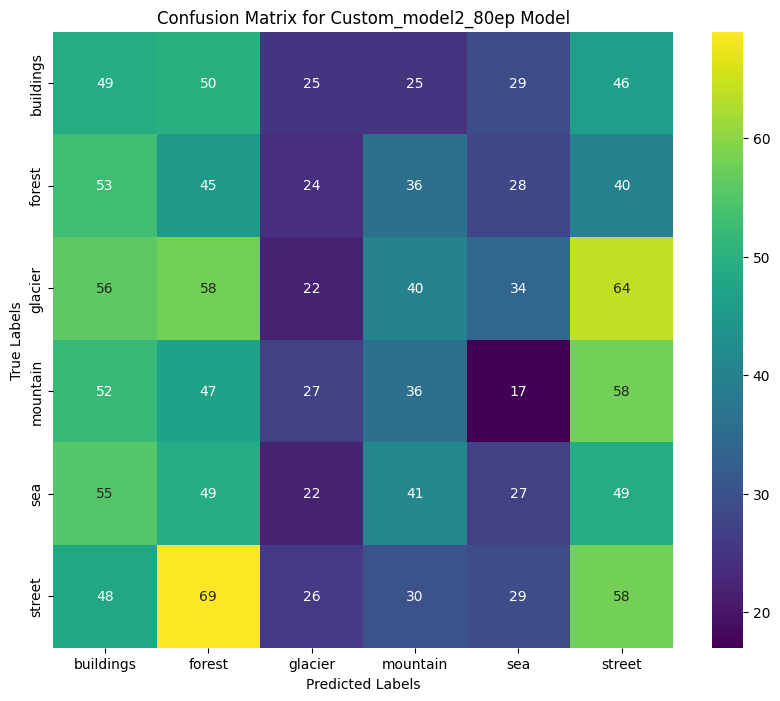

In [ ]:
# ploting the confusiion matrix for custom_model2
plot.plot_confusion_mat(test_true_labels, np.argmax(custom_model2_80ep_predict, axis=1),
                        class_names, "Custom_model2_80ep")

In [ ]:
# predicting labels for the testing data
custom_model2_200ep_predict = custom_model2_200ep.predict(test_data)

6/6 [==============================] - 0s 20ms/step


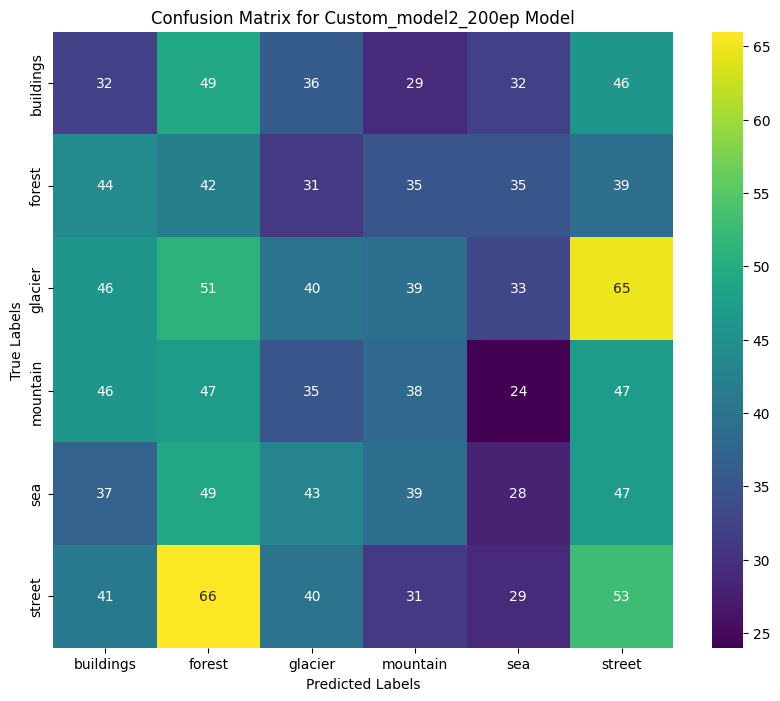

In [ ]:
# ploting the confusiion matrix for custom_model2
plot.plot_confusion_mat(test_true_labels, np.argmax(custom_model2_200ep_predict, axis=1),
                       class_names, "Custom_model2_200ep")